In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from nltk import word_tokenize as tokenize
import pandas as pd, csv
import operator
import os,random,math
import numpy as np


torch.manual_seed(1)
device = torch.device("cuda:0")

In [14]:
from nltk import word_tokenize as tokenize

CONTEXT_SIZE = 2  
EMBEDDING_DIM = 10  
# We will use Shakespeare Sonnet 2
test_sentence = ["__END","__START"]+tokenize("""When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""")+["__END"]

# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
# print the last 3, just so you can see what they look like
print(trigrams[-3:])

[(["feel'st", 'it'], 'cold'), (['it', 'cold'], '.'), (['cold', '.'], '__END')]


In [15]:
vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

In [16]:
import os
TRAINING_DIR="D:\Study\自然语言工程\高级\week2\lab2resources\lab2resources\sentence-completion\Holmes_Training_Data"  #this needs to be the parent directory for the training corpus

def get_training_testing(training_dir=TRAINING_DIR,split=0.5):

    filenames=os.listdir(training_dir)
    n=len(filenames)
    print("There are {} files in the training directory: {}".format(n,training_dir))
    random.seed(53)  #if you want the same random split every time
    random.shuffle(filenames)
    index=int(n*split)
    return(filenames[:index],filenames[index:])

trainingfiles,heldoutfiles=get_training_testing()

There are 522 files in the training directory: D:\Study\自然语言工程\高级\week2\lab2resources\lab2resources\sentence-completion\Holmes_Training_Data


In [17]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embedding_dim=embedding_dim
        self.context_size=context_size
        self.hidden_size=128
        
    def initialise(self):
        
        self.embeddings = nn.Embedding(self.vocab_size, self.embedding_dim).to(device)
        self.linear1 = nn.Linear(self.context_size * self.embedding_dim, self.hidden_size).to(device)
        self.linear2 = nn.Linear(self.hidden_size, self.vocab_size).to(device)

    def forward(self, inputs):
      
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

    def get_logprob(self,context,target):
        device = torch.device("cuda:0")
        #return the logprob of the target word given the context
        context_idxs = torch.tensor([self.word_to_ix[w] for w in context], dtype=torch.long)
        log_probs = self.forward(context_idxs)
        target_idx=torch.tensor(self.word_to_ix[target],dtype=torch.long)
        return log_probs.index_select(1,target_idx).item()
        
        
    def nextlikely(self,context):
        #sample the distribution of target words given the context
        context_idxs = torch.tensor([self.word_to_ix[w] for w in context], dtype=torch.long)
        log_probs = self.forward(context_idxs)
        probs=[math.exp(x) for x in log_probs.flatten().tolist()]
        t=random.choices(list(range(len(probs))),weights=probs,k=1)
        return self.ix_to_word[t[0]]
    
    def generate(self,limit=20):
        #generate a sequence of tokens according to the model
        tokens=["__END","__START"]
        while tokens[-1]!="__END" and len(tokens)<limit:
            current=self.nextlikely(tokens[-2:])
            tokens.append(current)
        return " ".join(tokens[2:-1])
    
    def train(self,inputngrams,loss_function=nn.NLLLoss(),lr=0.001,epochs=10):
        
        optimizer=optim.SGD(self.parameters(),lr=lr)
        
        losses=[]
        for epoch in range(epochs):
            total_loss = 0
            for context, target in inputngrams:

                # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
                # into integer indices and wrap them in tensors)
                context_idxs = torch.tensor([self.word_to_ix[w] for w in context], dtype=torch.long).to(device)

                # Step 2. Recall that torch *accumulates* gradients. Before passing in a
                # new instance, you need to zero out the gradients from the old
                # instance
                self.zero_grad()

                # Step 3. Run the forward pass, getting log probabilities over next
                # words
                log_probs = self.forward(context_idxs)

                # Step 4. Compute your loss function. (Again, Torch wants the target
                # word wrapped in a tensor)
                wordto_ix = torch.tensor([self.word_to_ix[target]], dtype=torch.long).to(device)
                loss = loss_function(log_probs, wordto_ix)

                # Step 5. Do the backward pass and update the gradient
                loss.backward()
                optimizer.step()
            
                # Get the Python number from a 1-element Tensor by calling tensor.item()
                total_loss += loss.item()
            losses.append(total_loss)
            print("Completed epoch {} with loss {}".format(epoch,total_loss))
        return losses
        
    
    def train_from_corpus(self,training_dir=TRAINING_DIR,files=[]):
        alltokens=["__END"]
        #reading corpus and tokenize
        for afile in files:
            print("Reading {}".format(afile))
            try:
                with open(os.path.join(training_dir,afile)) as instream:
                    for line in instream:
                        line=line.rstrip()
                        if len(line)>0:
                            tokens=["__START"]+tokenize(line)+["__END"]
                            alltokens+=tokens
            except UnicodeDecodeError:
                print("UnicodeDecodeError reading {}: ignoring file".format(afile))
        
        
        #get the vocab and build the indexes
        self.vocab = set(alltokens)
        self.word_to_ix = {word: i for i, word in enumerate(self.vocab)}
        self.ix_to_word = {i: word for i, word in enumerate(self.vocab)}
        
        #MUST SET THE VOCAB SIZE and INITIALISE THE NN
        self.vocab_size=len(self.vocab) 
        print("Vocabulary size is {}".format(self.vocab_size))
        self.initialise()
        
        #convert to trigrams
        trigrams = [([alltokens[i], alltokens[i + 1]], alltokens[i + 2])
            for i in range(len(alltokens) - 2)]
        
        print("Starting training")
        #train using the trigrams
        self.train(trigrams)

In [18]:
MAX_FILES=1
model = NGramLanguageModeler(EMBEDDING_DIM, CONTEXT_SIZE)
model.train_from_corpus(files=trainingfiles[:MAX_FILES])

Reading DYNMT10.TXT
Vocabulary size is 9347
Starting training


KeyboardInterrupt: 

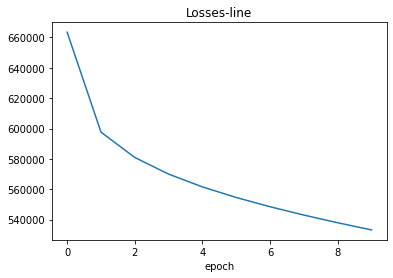

In [19]:
import matplotlib.pyplot as plt
loss = [663424.6739484835,597613.0026421341,580916.226916865,569946.9342714975,561527.4023481769,554543.3517483986,548449.8168717449,542956.8089499564,537906.380108112,533183.2371414312]
fig = plt.figure(1)
ax = plt.subplot(111)
ax.plot(loss)

plt.xlabel('epoch')
plt.title('Losses-line')
plt.show()